In [3]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)  # Using json.loads instead of eval()

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')



In [18]:
df = getDF('Cell_Phones_and_Accessories_5.json.gz')

In [5]:
df.sample(10)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
931651,5.0,True,"07 25, 2016",A2UIN31CILV893,B01B12PTOM,{'Color:': ' White'},Kelsey Vineyard,I bought two of the Anker PowerCore 10000 port...,Best decision ever!,1469404800,NaN,NaN
350677,4.0,True,"05 22, 2015",A2ET8M30Z1E64T,B00H99DBFQ,NaN,Jack33,Nice balance of battery size and weight. Not ...,Light and Ample Power,1432252800,NaN,NaN
579543,5.0,True,"04 8, 2015",A1868C310KE2D4,B00OBSPWD2,{'Color:': ' 3m-PVC White'},ClockworkOrangutan,This charging cable works great. Price is mor...,Works great,1428451200,NaN,NaN
969919,5.0,True,"10 18, 2016",A2ILPGF4YVTVSX,B01D88TCTU,{'Color:': ' Pink'},Hayley K.,"Super cute, when I get bored I play flip my ph...",Cute,1476748800,NaN,NaN
957523,4.0,True,"01 12, 2017",A4VEKNHHOZIMJ,B01CG3KW24,NaN,Kris,"Works good, had to use box knife to trim some ...","Works OK, not Great.",1484179200,NaN,NaN
224615,5.0,True,"05 27, 2015",A26JYH08A2LJ4F,B00C1DIGRI,{'Color:': ' Black'},Freddy A. Rodriguez B.,Excelent,Five Stars,1432684800,NaN,NaN
1078722,5.0,True,"03 5, 2015",A2PCQQ2LQ1BOCH,B00KC6DPWC,NaN,Lorraine LeBlanc,great fit and easy access to phone,Five Stars,1425513600,NaN,NaN
1033800,5.0,True,"02 7, 2014",A14E6QYNOC8BRG,B004369G9S,"{'Color:': ' Black Zebra', 'Package Type:': ' ...",brian boland,I would purchase more if I needed them. Works ...,Great product!!!,1391731200,NaN,NaN
195676,2.0,True,"03 17, 2014",ARYHVYJQ5IZ2M,B00AX8M570,"{'Size:': ' Samsung Galaxy S4', 'Color:': ' Bl...",SumTingRight,The case does what it's supposed to do when it...,Kickstand,1395014400,NaN,NaN
291463,5.0,True,"01 27, 2016",A35KPJJJLBG12N,B00ESJ43FW,"{'Size:': ' One Size', 'Color:': ' Red', 'Pack...",Sharon,Great backup charger. Would be better if it ga...,Five Stars,1453852800,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1128437 entries, 0 to 1128436
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1128437 non-null  float64
 1   verified        1128437 non-null  bool   
 2   reviewTime      1128437 non-null  object 
 3   reviewerID      1128437 non-null  object 
 4   asin            1128437 non-null  object 
 5   style           605241 non-null   object 
 6   reviewerName    1128302 non-null  object 
 7   reviewText      1127672 non-null  object 
 8   summary         1127920 non-null  object 
 9   unixReviewTime  1128437 non-null  int64  
 10  vote            92034 non-null    object 
 11  image           27107 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 104.4+ MB


In [7]:
df.isna().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              523196
reviewerName          135
reviewText            765
summary               517
unixReviewTime          0
vote              1036403
image             1101330
dtype: int64

In [8]:
(df.isna().sum())/(df.shape[0])

overall           0.000000
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
style             0.463647
reviewerName      0.000120
reviewText        0.000678
summary           0.000458
unixReviewTime    0.000000
vote              0.918441
image             0.975978
dtype: float64

In [9]:
((df.isna().sum())/1128437)*100

overall            0.000000
verified           0.000000
reviewTime         0.000000
reviewerID         0.000000
asin               0.000000
style             46.364662
reviewerName       0.011963
reviewText         0.067793
summary            0.045816
unixReviewTime     0.000000
vote              91.844117
image             97.597828
dtype: float64

In [10]:
df[['overall']].value_counts(normalize=True)

overall
5.0        0.626564
4.0        0.163439
3.0        0.087071
1.0        0.072258
2.0        0.050667
Name: proportion, dtype: float64

In [11]:
df['verified'].value_counts(normalize=True)

verified
True     0.874948
False    0.125052
Name: proportion, dtype: float64

In [12]:
pd.to_datetime(df['reviewTime'])


0         2014-08-04
1         2014-02-12
2         2014-02-08
3         2014-02-04
4         2014-02-03
             ...    
1128432   2016-12-22
1128433   2016-07-15
1128434   2016-07-14
1128435   2016-07-13
1128436   2017-05-11
Name: reviewTime, Length: 1128437, dtype: datetime64[ns]

Lets make a simplified version containing only rating and text review and summar

Entires with no review won't be too helpful, so we can drop them. 

In [13]:
def simplifyReviews(dataframe):
    '''
    assumes data from amazon reviews, outputs new dataframe with only verified reviews containing overall rating, review and summary

    '''
    out = dataframe.copy()
    out = out[["overall", "verified", "reviewText", "summary"]]
    out = out[out["verified"]==True]
    out = out.drop("verified", axis=1)
    out.info()
    out = out.dropna()
    return out
    

In [14]:
def rating_distribution(data):

    values, counts = np.unique(data['overall'], return_counts=True)
    normalized_counts = counts/counts.sum()

    plt.figure()
    plt.bar(values, normalized_counts * 100)
    plt.xlabel("Review rating")
    plt.ylabel('% of reviews')
    plt.title("Rating distribution")
    plt.show()
    return normalized_counts
    

In [15]:
# df1 = pd.read_csv("clean_technology_reviews.csv")

/var/folders/z_/0wg44qzj7zzg40_5yymhjxm40000gn/T/ipykernel_49674/1323265529.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("clean_technology_reviews.csv")


In [19]:
df2 = getDF("Office_Products_5.json.gz")

# df2 = pd.read_csv("clean_office_reviews.csv")

In [20]:
df3 = getDF("Toys_and_Games_5.json.gz")
# df3 = pd.read_csv("")

In [21]:
tech_simple = simplifyReviews(df)
office_simple = simplifyReviews(df2)
toys_simple = simplifyReviews(df3)

<class 'pandas.core.frame.DataFrame'>
Index: 987324 entries, 0 to 1128436
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     987324 non-null  float64
 1   reviewText  986589 non-null  object 
 2   summary     986849 non-null  object 
dtypes: float64(1), object(2)
memory usage: 30.1+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 710187 entries, 0 to 800356
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     710187 non-null  float64
 1   reviewText  709987 non-null  object 
 2   summary     710066 non-null  object 
dtypes: float64(1), object(2)
memory usage: 21.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1599831 entries, 0 to 1828970
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   overall     1599831 non-null  float64
 1   reviewText  1598728 no

In [22]:
toys_simple

,overall,reviewText,summary
0,5.0,The stained glass pages are pretty cool. And i...,Nice book
1,5.0,My 11 y.o. loved this...and so do I (you know ...,Great pictures
2,5.0,"The pictures are great , I've done one and gav...","The pictures are great, I've done one and gave..."
3,5.0,I absolutely love this book! Its translucent p...,So beautiful!
4,5.0,I love it!,Five Stars
...,...,...,...
1828966,5.0,This was a huge hit. I had purchased this and ...,Huge hit
1828967,1.0,Ours didn't work! Only 3 worked out of the wh...,Don't buy!
1828968,5.0,Simple plaything. Even my grandson cant break ...,Five Stars
1828969,5.0,These work well and are a nice change from the...,Good value


In [23]:
# Save these as csvs

tech_simple.to_csv("clean_technology_reviews.csv")
office_simple.to_csv("clean_office_reviews.csv")
toys_simple.to_csv("clean_toys_reviews.csv")

We can read in the data from these csvs in future.

In [ ]:
tech_simple

,overall,reviewText,summary
0,5.0,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it
1,5.0,When you don't want to spend a whole lot of ca...,1
2,3.0,"so the case came on time, i love the design. I...",Its okay
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE
4,4.0,"I liked it because it was cute, but the studs ...",Cute!
...,...,...,...
1128429,4.0,Very good cell phone holster. Keeps my phone ...,Four Stars
1128430,1.0,Mediocre case protection. Clip is junk. Broke/...,One Star
1128431,3.0,my sons likes it. For the price it isn't too bad,Three Stars
1128432,4.0,Good for viewing. But doesn't have a button or...,Good


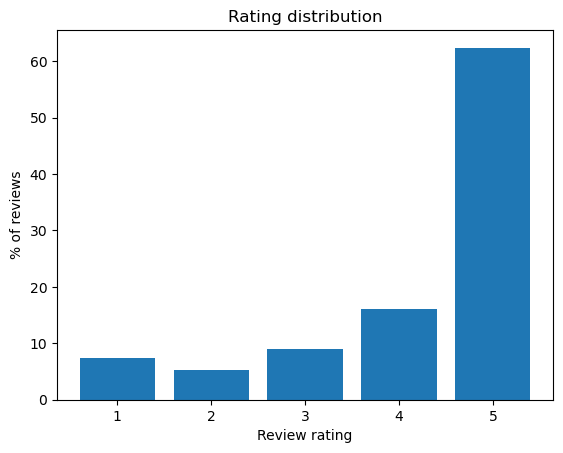

array([0.07475422, 0.05216571, 0.08910983, 0.15997424, 0.62399598])

In [24]:
rating_distribution(tech_simple)

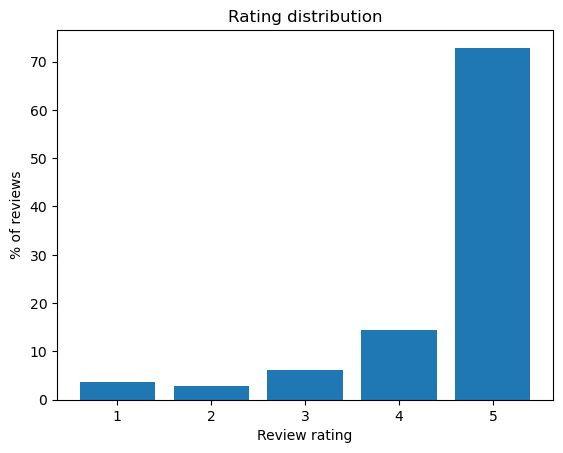

array([0.0365442 , 0.02863442, 0.06099341, 0.14521328, 0.7286147 ])

In [26]:
rating_distribution(office_simple)

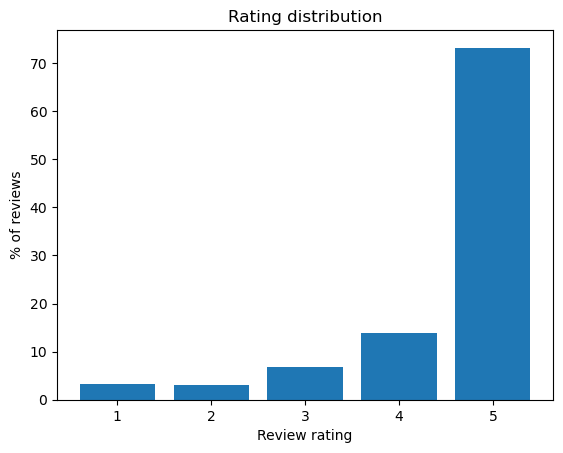

array([0.03177404, 0.02984212, 0.06805442, 0.13868264, 0.73164678])

In [25]:
rating_distribution(toys_simple)

In [ ]:
pd.DataFrame(np.unique(tech_simple['overall'], return_counts=True))

,0,1,2,3,4
0,1.0,2.0,3.0,4.0,5.0
1,73720.0,51444.0,87877.0,157761.0,615363.0


In [ ]:
pd.DataFrame(np.unique(office_simple['overall'], return_counts=True))

,0,1,2,3,4
0,1.0,2.0,3.0,4.0,5.0
1,25942.0,20327.0,43298.0,103084.0,517229.0


In [ ]:
pd.DataFrame(np.unique(toys_simple['overall'], return_counts=True))

,0,1,2,3,4
0,1.0,2.0,3.0,4.0,5.0
1,50788.0,47700.0,108779.0,221672.0,1169473.0


We see that the majority of the reviews are 5 stars, in the tech reviews, "only" 62% are 5 star, so I will use this as it is lowest.

In [110]:
tech_simple.head(10)


,overall,reviewText,summary
0,5.0,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it
1,5.0,When you don't want to spend a whole lot of ca...,1
2,3.0,"so the case came on time, i love the design. I...",Its okay
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE
4,4.0,"I liked it because it was cute, but the studs ...",Cute!
5,2.0,The product looked exactly like the picture an...,Not so happy
6,3.0,I FINALLY got my case today. It took forever t...,It's cute!
7,5.0,It is a very cute case. None of the jewels hav...,Cute case
8,1.0,DO NOT BUY! this item is seriously cheap as he...,WORST ITEM!
9,4.0,I really love this case... you have to keep yo...,Pretty Cute!


In [27]:
rev_len = list()
for review in tech_simple["reviewText"]:
    rev_len.append(len(review))

In [28]:
tech_simple["length"] = rev_len

In [29]:
tech_simple["length"].describe()

count    986165.000000
mean        209.004199
std         363.109492
min           1.000000
25%          34.000000
50%         108.000000
75%         240.000000
max       33457.000000
Name: length, dtype: float64

In [30]:
a = tech_simple.loc[728545, 'reviewText']
a

'This phone seemed nothing short of a dream come true for any remaining Symbian fans -- all 3 of us!  Prior to its introduction at MWC last February, I was getting a bit dismayed by the lack of good choices out there.  I was getting bored with my aging&nbsp;<a data-hook="product-link-linked" class="a-link-normal" href="/Nokia-N8/dp/B003ZX7RNC/ref=cm_cr_arp_d_rvw_txt?ie=UTF8">Nokia N8</a>&nbsp;from 2010, but almost 2 years later, nothing else could match its camera, its offline navigation, its connectivity options, or - this may be a bit of a surprise if you read too many blogs - its usability.  The prospects of another bone thrown our way from Nokia were pretty slim too: In 2011 Nokia\'s new CEO, Microsoft lackey Stephen Elop, gave the Symbian OS the death sentence and instead hijacked the company as a tool to use in a last ditch (futile) attempt to promote Windows Phone, thus _instantly_ killing off Nokia\'s then-40+% share of the global smartphone market.\n\nThen - out of nowhere - c

Our model probably won't be able to handle essays, so we can remove this review and then try view the distribuition of review lengths.

In [31]:
tech_simple = tech_simple.drop(index=728545)



In [53]:
tech_simple["length"].describe()
short_car = tech_simple[tech_simple["length"]<=250]
short_car.describe()

,overall,length
count,751174.000000,751174.000000
mean,4.277792,83.988004
std,1.215613,68.317762
min,1.000000,1.000000
25%,4.000000,23.000000
50%,5.000000,67.000000
75%,5.000000,132.000000
max,5.000000,250.000000


In [54]:
short_car

,overall,reviewText,summary,length
1,5.0,When you don't want to spend a whole lot of ca...,1,102
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,92
4,4.0,"I liked it because it was cute, but the studs ...",Cute!,150
5,2.0,The product looked exactly like the picture an...,Not so happy,159
8,1.0,DO NOT BUY! this item is seriously cheap as he...,WORST ITEM!,190
...,...,...,...,...
1128429,4.0,Very good cell phone holster. Keeps my phone ...,Four Stars,79
1128430,1.0,Mediocre case protection. Clip is junk. Broke/...,One Star,62
1128431,3.0,my sons likes it. For the price it isn't too bad,Three Stars,48
1128432,4.0,Good for viewing. But doesn't have a button or...,Good,142


In [55]:
l_values, l_counts = np.unique(short_car['length'], return_counts=True)

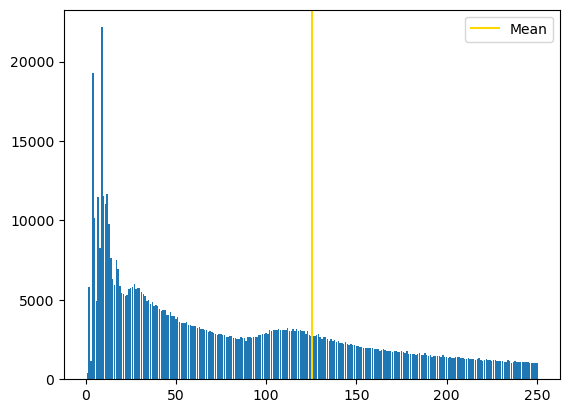

In [56]:
plt.figure()
plt.bar(l_values, l_counts)
plt.axvline(l_values.mean(), color='gold', label="Mean")

plt.legend()
plt.show()

In [57]:
# tokenising the reviews:
short_car['reviewText'].str.split(' ')

1          [When, you, don't, want, to, spend, a, whole, ...
3          [DON'T, CARE, FOR, IT., , GAVE, IT, AS, A, GIF...
4          [I, liked, it, because, it, was, cute,, but, t...
5          [The, product, looked, exactly, like, the, pic...
8          [DO, NOT, BUY!, this, item, is, seriously, che...
                                 ...                        
1128429    [Very, good, cell, phone, holster., , Keeps, m...
1128430    [Mediocre, case, protection., Clip, is, junk.,...
1128431    [my, sons, likes, it., For, the, price, it, is...
1128432    [Good, for, viewing., But, doesn't, have, a, b...
1128436                                        [i, love, it]
Name: reviewText, Length: 751174, dtype: object

In [58]:
short_car['reviewText'] = short_car['reviewText'].str.lower()
# short_car['reviewText'] = short_car['reviewText'].str.replace("[^a-z']", " ")


/var/folders/z_/0wg44qzj7zzg40_5yymhjxm40000gn/T/ipykernel_49674/2268284213.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_car['reviewText'] = short_car['reviewText'].str.lower()


## TEST PHASE

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

In [60]:
def bow_review(review): 
    # 1. Instantiate 
    bagofwords = CountVectorizer()

    # 2. Fit 
    bagofwords.fit(review['reviewText'])

    # 3. Transform
    small_transformed = bagofwords.transform(review['reviewText'])
    small_transformed
    return(bagofwords, small_transformed)
bow_short, s_transformed_short = bow_review(short_car)

In [61]:
# these are now the features, they are the individual tokens
# bagofwords.get_feature_names()

bow_short.get_feature_names()
corpus = bow_short.get_feature_names()
# converting the sparse matrix into a numpy array
# small_transformed.toarray()
print(s_transformed_short.shape[0] * s_transformed_short.shape[1] * s_transformed_short.dtype.itemsize / 1e6)
print(s_transformed_short.shape)

315360.873376
(751174, 52478)


In [47]:
term_frequencies = s_transformed_short.sum(axis=0)
term_frequencies.shape

(1, 74997)

In [ ]:
corpus

In [65]:
import nltk
nltk.download('words')



[nltk_data] Downloading package words to /Users/edo/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [69]:
english_words = set(nltk.corpus.words.words())
unrecognized_tokens = [token for token in corpus if token.lower() not in english_words]
num_unrec = len(unrecognized_tokens)
num_unrec/len(corpus)

0.7133084340104424

In [73]:
from collections import Counter
unrecognized_token_freq = Counter(unrecognized_tokens)
unrecognized_freq = {token: freq for token, freq in unrecognized_token_freq.items() if token in unrecognized_tokens}


In [84]:
from sklearn.cluster import DBSCAN
import Levenshtein

# Sample tokens
tokens = corpus

# Create a distance matrix
dist_matrix = np.zeros((len(tokens), len(tokens)))
for i, token1 in enumerate(tokens):
    for j, token2 in enumerate(tokens):
        if i > j:
            # Levenshtein distance can be normalized (divided by max(len(token1), len(token2))) 
            # to be in [0,1] if needed
            dist_matrix[i, j] = Levenshtein.distance(token1, token2)
            dist_matrix[j, i] = dist_matrix[i, j]  # Symmetric matrix

# Cluster with DBSCAN
db = DBSCAN(metric='precomputed', eps=2, min_samples=2)  # eps is the max distance for two samples to be in the same neighborhood
clusters = db.fit_predict(dist_matrix)

# Show clusters
for cluster_id in set(clusters):
    print(f"Cluster {cluster_id}: {[tokens[i] for i in np.where(clusters == cluster_id)[0]]}")


KeyboardInterrupt: 

We should work on a sample of the data:

In [48]:
from sklearn.utils import resample
subset_transformed = resample(s_transformed_short, n_samples=1000, random_state=42, replace=False)
subset_transformed.todense()
# fre = pd.DataFrame(columns=bagofwords.get_feature_names(), data=subset_transformed.todense())
# display(free)


In [52]:
corpus[10000:]

['believe',
 'believed',
 'believer',
 'believes',
 'believing',
 'belikn',
 'belip',
 'belisismo',
 'belit',
 'belittle',
 'belive',
 'beliver',
 'belize',
 'belk',
 'belken',
 'belkeve',
 'belkin',
 'belking',
 'belkins',
 'bell',
 'bella',
 'belle',
 'bellevue',
 'belleza',
 'bellied',
 'bellies',
 'bellisimo',
 'bellisssimo',
 'bellkin',
 'bello',
 'bellow',
 'bellroy',
 'bells',
 'bellt',
 'belly',
 'belong',
 'belonged',
 'belonging',
 'belongings',
 'belongs',
 'beloved',
 'beloving',
 'below',
 'belows',
 'belreak',
 'belst',
 'belt',
 'belta',
 'beltcase',
 'beltclip',
 'beltclips',
 'belted',
 'beltholder',
 'beltline',
 'beltloop',
 'beltron',
 'belts',
 'beluga',
 'bely',
 'beminimal',
 'bemt',
 'bemused',
 'bemz',
 'ben',
 'bench',
 'benched',
 'benches',
 'benching',
 'benchmade',
 'benchmark',
 'benchmarked',
 'benchmarking',
 'benchmarks',
 'bend',
 'bendability',
 'bendable',
 'bended',
 'bender',
 'bendgate',
 'bendind',
 'bending',
 'bends',
 'bendy',
 'bene',
 'bene

## Cleaning the text data 

In [130]:
bow_short2, s_transformed_short2 = bow_review(short_car)

In [140]:
corpus2 = bow_short2.get_feature_names()
corpus2[50:60]


['0hone', '0k', '0m', '0nly', '0ok', '0onnector', '0qc', '0s', '0v', '0ver']

In [132]:
import re
short_car['reviewText'] = short_car['reviewText'].apply(lambda x: ' '.join(word for word in x.split() if not re.search(r'\d', word)))


/var/folders/z_/0wg44qzj7zzg40_5yymhjxm40000gn/T/ipykernel_47862/1725954875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_car['reviewText'] = short_car['reviewText'].apply(lambda x: ' '.join(word for word in x.split() if not re.search(r'\d', word)))


In [135]:
bow_short3, s_transformed_short3 = bow_review(short_car)


AttributeError: 'CountVectorizer' object has no attribute 'shape'

In [136]:
s_transformed_short3.shape

(740668, 47431)

In [139]:
corpus3 = bow_short3.get_feature_names()
corpus3[10:100]

['_hakflduayk',
 '_including',
 '_indostructable_',
 '_innergear',
 '_lot_',
 '_not_',
 '_ontar',
 '_precisely_',
 '_really_',
 '_slip__',
 '_ss',
 'a_',
 'a_s',
 'aa',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaaa',
 'aaaaaaa',
 'aaaaaaaa',
 'aaaaaaaaa',
 'aaaaaaaaaa',
 'aaaaaaaaaaaa',
 'aaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaa',
 'aaaaaand',
 'aaaaammmmaaaaazzzziiiiinnnngggg',
 'aaaaand',
 'aaaah',
 'aaaahhhhh',
 'aaaamazon',
 'aaaannnhhh',
 'aaaass',
 'aaagood',
 'aaas',
 'aabout',
 'aabsolutely',
 'aacute',
 'aadhesive',
 'aaf',
 'aagin',
 'aah',
 'aahs',
 'aall',
 'aalso',
 'aam',
 'aamazon',
 'aame',
 'aand',
 'aaply',
 'aapop',
 'aaps',
 'aare',
 'aargh',
 'aarived',
 'aaron',
 'aas',
 'aatter',
 'aawesome',
 'aaxa',
 'ab',
 'aback',
 'abacus',
 'abad',
 'abajo',
 'abandon',
 'abandoned',
 'abandoning',
 'abating',
 'abattery',
 'abbreviated',
 'abby',
 'abc',
 'abcs',
 'abd',
 'abe',
 'aberration',
 'aberrations',
 'abest',
 'abet',
 'abetted',
 'abetter',
 'abhor',
 'abide',
 'abiertas',


In [181]:
def fragmenter(corp):
    corpus_length = len(corp)
    corpus_length = round(corpus_length,-2)
    batch = int(corpus_length/1000)+1
    corpus_dict = {}
    for i in range(1,batch+2):
        corpus_dict[i] = corp[(i-1)*1000:i*1000]
    return corpus_dict, batch

frag_corpus2, batch2 = fragmenter(corpus2)
frag_corpus2[1]



['00',
 '000',
 '0000',
 '000000',
 '000amh',
 '000amp',
 '000ma',
 '000mah',
 '001',
 '002',
 '004',
 '007',
 '00am',
 '00ma',
 '00pm',
 '01',
 '010',
 '0100',
 '011935003731469',
 '0155379',
 '01890',
 '01c',
 '01pm',
 '02',
 '025',
 '0251',
 '02mm',
 '03',
 '04',
 '0401',
 '05',
 '050',
 '050mah',
 '05v',
 '06',
 '060',
 '06mb',
 '07',
 '08',
 '08mm',
 '09',
 '0a',
 '0amp',
 '0amps',
 '0c',
 '0ce',
 '0db',
 '0f',
 '0ff',
 '0h9ne',
 '0hone',
 '0k',
 '0m',
 '0nly',
 '0ok',
 '0onnector',
 '0qc',
 '0s',
 '0v',
 '0ver',
 '0vrg',
 '0w',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '1000000',
 '10000ma',
 '10000mah',
 '10000x',
 '1000ma',
 '1000mah',
 '1000rf6',
 '1000s',
 '1000stars',
 '1000x',
 '10050',
 '10050mah',
 '100betterthan',
 '100deg',
 '100ma',
 '100mah',
 '100mb',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100times',
 '100w',
 '100x',
 '101',
 '1010ma',
 '1016',
 '101th',
 '102',
 '1020',
 '103',
 '1036',
 '103yo',
 '1040',
 '10400',
 '10400ma',
 '10400mah',
 '105',
 '106f',
